In [14]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import RepeatedKFold, cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [15]:
excel_path = 'Data/pca_results.xlsx'   
header_row = 0                                  
year_min, year_max = 1490, 1995

In [16]:
df = pd.read_excel(excel_path, header=header_row)


mask = (df['YEAR'] >= year_min) & (df['YEAR'] <= year_max)
df_years = df.loc[mask].copy()


df_years = df_years.set_index('YEAR')


In [17]:
nf = pd.read_excel('Data/Measured Streamflow in MAF.xlsx', header=0, index_col=0)

target_col = "Meko Paper"
year_min, year_max = 1906, 1995

# 1) Make sure indices are numeric and sorted
nf = nf.copy()
df_years = df_years.copy()
nf.index = pd.to_numeric(nf.index, errors='coerce')
df_years.index = pd.to_numeric(df_years.index, errors='coerce')
nf = nf.sort_index()
df_years = df_years.sort_index()

# 2) Use only predictor/site columns (exclude 'YEAR' since it's the index)
site_cols = [c for c in df_years.columns if c != 'YEAR']

# 3) Slice by year and inner-join to align rows
X_raw = df_years.loc[year_min:year_max, site_cols]
y_raw = nf.loc[year_min:year_max, target_col]
data = X_raw.join(y_raw, how="inner").dropna(axis=0)
X = data[site_cols]
y = data[target_col]

print(f"Years used: {int(data.index.min())}–{int(data.index.max())}, n={len(data)}")
print(f"Predictors available: {X.shape[1]}")

Years used: 1906–1995, n=90
Predictors available: 30


In [19]:
X_one = X[["PC 1"]]  

# --- Define model ---
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

# --- Training R² (in-sample) ---
pipe.fit(X_one, y)
y_pred = pipe.predict(X_one)
r2_in = r2_score(y, y_pred)
print(f"In-sample R² with 1 predictor (PC 1): {r2_in:.4f}")

# --- Cross-validated R² ---
cv1 = RepeatedKFold(n_splits=3, n_repeats=10, random_state=42)
cv_scores = cross_val_score(pipe, X_one, y, scoring="r2", cv=cv1, n_jobs=-1)
print(f"Cross-validated R² with 1 predictor (PC 1): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

In-sample R² with 1 predictor (PC 1): 0.7701
Cross-validated R² with 1 predictor (PC 1): 0.7506 ± 0.0561


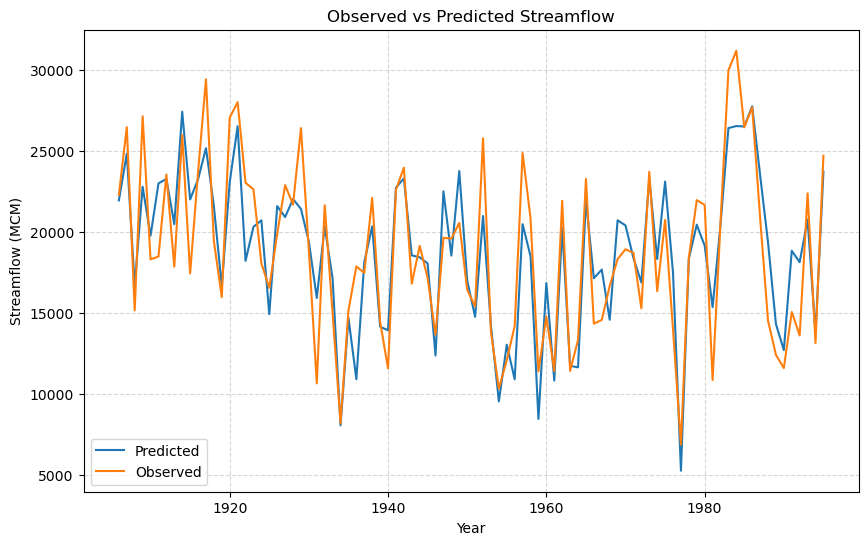

In [25]:
plt.figure(figsize=(10,6))
plt.plot(X_raw.index, y_pred, label="Predicted")
plt.plot(X_raw.index, y_raw, label="Observed")
plt.xlabel('Year')
plt.ylabel('Streamflow (MCM)')
plt.title('Observed vs Predicted Streamflow')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

df_out = pd.DataFrame({
    'Year': X_raw.index,
    'Observed_Streamflow': y_raw,
    'Predicted_Streamflow regression (pca)': y_pred
})

# Save to Excel
df_out.to_excel('Observed_vs_Predicted_Streamflow - 1-pca_new.xlsx', index=False)

In [38]:
TR_START, TR_END = 1490, 1995
    
X_paleo = df_years.iloc[:, [0]].loc[TR_START:TR_END]

# --- Predict with Stepwise / Linear model ---
recon_stepwise = pd.Series(pipe.predict(X_paleo), index=X_paleo.index, name='recon_stepwise')


# --- Combine & save to Excel ---
out = pd.DataFrame(index=X_paleo.index)
out["recon_stepwise"] = recon_stepwise


excel_path = "reconstruction_PCA_new.xlsx"
with pd.ExcelWriter(excel_path, engine="xlsxwriter") as writer:
    out.to_excel(writer, sheet_name="reconstruction")
    # add a small metadata sheet
    meta = pd.DataFrame({
        "item": ["window", "models_included", "notes"],
        "value": [f"{TR_START}-{TR_END}",
                  "stepwise" ,
                  "Units follow your training target; verify scaling if needed."]
    })
    meta.to_excel(writer, sheet_name="meta", index=False)

print(f"Saved: {excel_path}")

Saved: reconstruction_PCA_new.xlsx
